# Component analysis


##### Nowadays, standard Git and Issue Tracking is used for project development. This provides a new way to associate components of the application code with git-commits and issues in order to detect possible hotspots .

# 1. Connection of bugs and issues with application code (google issues)

## a) Classification of issues

### 1.Create a connection to the Neo4j database 

#### Establish a connection to the Neo4j database.

In [21]:
import py2neo

graph = py2neo.Graph(bolt=True, host='localhost', user='neo4j', password='0000')

### 2.Set Cypher-Query

#### Make a query to the database. Store the result in a dataframe (pandas).

In [22]:
import pandas as pd
query ="MATCH (n:Issue) RETURN n.issueId, n.title as title, n.body as body, n.createdAt as Time"
df = pd.DataFrame(graph.run(query).data())

In [23]:
df.head(5)





,n.issueId,title,body,Time
0,TheHolyWaffle/TeamSpeak-3-Java-API#330,Timeout,I have this Error\n\n2019-05-26 20:46:06.007 [...,20190526184919
1,TheHolyWaffle/TeamSpeak-3-Java-API#329,insufficient client permissions which (at leas...,"Exception in thread ""main"" com.github.theholyw...",20190524190551
2,TheHolyWaffle/TeamSpeak-3-Java-API#328,[DEBUG] Random Socket Read Time Out,After a long uptime of my bot I get a random:\...,20190511214257
3,TheHolyWaffle/TeamSpeak-3-Java-API#327,Connect to Server Issue,"Hey, I just cloned your repo and compiled myse...",20190509185745
4,TheHolyWaffle/TeamSpeak-3-Java-API#375,TextMessage,"Hey,\nif i try to send a message to the bot, t...",20200804111854



### 3.Preprocessing data

#### Preparation of the data quality by using different methods

####    - remove NaN
####    - remove all digit, special word, whitespace
####    - convert in lower case
####    - remove Stop-Words
####    - remove all non Words






##### Noisy data in column: "body"

In [24]:
df["body"].head(5)

0    I have this Error\n\n2019-05-26 20:46:06.007 [...
1    Exception in thread "main" com.github.theholyw...
2    After a long uptime of my bot I get a random:\...
3    Hey, I just cloned your repo and compiled myse...
4    Hey,\nif i try to send a message to the bot, t...
Name: body, dtype: object

In [25]:
import Processing.PreProcessing as p


df["full_body"] = df["body"] + df["title"]

#drop NaN rows
df=df.dropna()

#remove NaN
# remove all digit, special word, whitespace
# convert in lower case
# remove Stop-Words
#remove all non Words


df["full_body"]=df["full_body"].apply(lambda x: p.preprocess(x))

df.head(5)

,n.issueId,title,body,Time,full_body
0,TheHolyWaffle/TeamSpeak-3-Java-API#330,Timeout,I have this Error\n\n2019-05-26 20:46:06.007 [...,20190526184919,error error connection timed net read timed ne...
1,TheHolyWaffle/TeamSpeak-3-Java-API#329,insufficient client permissions which (at leas...,"Exception in thread ""main"" com.github.theholyw...",20190524190551,exception thread main exception command return...
2,TheHolyWaffle/TeamSpeak-3-Java-API#328,[DEBUG] Random Socket Read Time Out,After a long uptime of my bot I get a random:\...,20190511214257,long bot get random away voice times icon coun...
3,TheHolyWaffle/TeamSpeak-3-Java-API#327,Connect to Server Issue,"Hey, I just cloned your repo and compiled myse...",20190509185745,hey jar whenever try connect server got error ...
4,TheHolyWaffle/TeamSpeak-3-Java-API#375,TextMessage,"Hey,\nif i try to send a message to the bot, t...",20200804111854,hey try send message bot message client regist...


### 4.Classification with "text-model" 

#### SVM Model to predict Issue-Label 

In [26]:
import pickle

## Path 
filename='model_svm.sav'
filename_tfidf='tf_idf_model.sav'

#load models
classifier = pickle.load(open(filename, 'rb'))
tfidfconverter =pickle.load(open(filename_tfidf, 'rb'))

# fit and transform tfidf matrix from input text
X = tfidfconverter.fit_transform(df['full_body']).toarray()

y = classifier.predict(X)

# add class column  0: no critical issue 1: critical issue
df["class"]= y

df.head(5)

,n.issueId,title,body,Time,full_body,class
0,TheHolyWaffle/TeamSpeak-3-Java-API#330,Timeout,I have this Error\n\n2019-05-26 20:46:06.007 [...,20190526184919,error error connection timed net read timed ne...,0
1,TheHolyWaffle/TeamSpeak-3-Java-API#329,insufficient client permissions which (at leas...,"Exception in thread ""main"" com.github.theholyw...",20190524190551,exception thread main exception command return...,1
2,TheHolyWaffle/TeamSpeak-3-Java-API#328,[DEBUG] Random Socket Read Time Out,After a long uptime of my bot I get a random:\...,20190511214257,long bot get random away voice times icon coun...,0
3,TheHolyWaffle/TeamSpeak-3-Java-API#327,Connect to Server Issue,"Hey, I just cloned your repo and compiled myse...",20190509185745,hey jar whenever try connect server got error ...,0
4,TheHolyWaffle/TeamSpeak-3-Java-API#375,TextMessage,"Hey,\nif i try to send a message to the bot, t...",20200804111854,hey try send message bot message client regist...,0


## b) Get File-Names and associate with Issues


### 1. Set Query-Cypher

#### Query to find all filenames in the database

In [27]:
import pandas as pd
query ="MATCH (n) WHERE EXISTS(n.fileName)  RETURN DISTINCT  n.fileName AS fileName"
df_file = pd.DataFrame(graph.run(query).data())


In [28]:
df_file.head(5)

,fileName
0,/Users/fabian/.m2/repository/com/github/thehol...
1,/Users/fabian/.m2/repository/com/github/thehol...
2,/Users/fabian/.m2/repository/com/jcraft/jzlib/...
3,/Users/fabian/.m2/repository/com/hierynomus/ss...
4,/Users/fabian/.m2/repository/net/i2p/crypto/ed...


### 2. Process data

#### Search filename/classname in issue text for regonize as class specific issue

In [29]:
dict_file={}

import numpy as np 
def function(x,issue,i):  
    
    if i in x:
        if 'n.issueId' not in dict_file.keys():
            dict_file['n.issueId'] = [issue]

        if 'FileName' not in dict_file.keys():
            dict_file['FileName'] = [i]
            
        dict_file['n.issueId'].append(issue)
        dict_file['FileName'].append(i)
        
    else:
        return
    
    
#Create fileName List:      
name_list = np.array(df_file['fileName'])

# transform File-Path |delete ".class" | transform "/" to "."
name_list=p.formate_name(name_list)

# delete not relevant class/file Path 
name_list=p.delete_not_class(name_list)

In [30]:
print(name_list)

['Users.fabian..m2.repository.com.github.theholywaffle.teamspeak3-api.1.3.0-SNAPSHOT.teamspeak3-api-1.3.0-SNAPSHOT.jar', 'Users.fabian..m2.repository.com.github.theholywaffle.teamspeak3-api.1.3.0-SNAPSHOT.teamspeak3-api-1.3.0-SNAPSHOT.test-jar', 'Users.fabian..m2.repository.com.jcraft.jzlib.1.1.3.jzlib-1.1.3.jar', 'Users.fabian..m2.repository.com.hierynomus.sshj.0.27.0.sshj-0.27.0.jar', 'Users.fabian..m2.repository.net.i2p.crypto.eddsa.0.2.0.eddsa-0.2.0.jar', 'Users.fabian..m2.repository.org.bouncycastle.bcpkix-jdk15on.1.60.bcpkix-jdk15on-1.60.jar', 'Users.fabian..m2.repository.org.slf4j.slf4j-api.1.7.7.slf4j-api-1.7.7.jar', 'Users.fabian..m2.repository.org.bouncycastle.bcprov-jdk15on.1.60.bcprov-jdk15on-1.60.jar', 'Users.fabian..m2.repository.org.slf4j.slf4j-api.1.7.25.slf4j-api-1.7.25.jar', 'Users.fabian..m2.repository.org.slf4j.slf4j-simple.1.7.25.slf4j-simple-1.7.25.jar', 'Users.fabian..m2.repository.junit.junit.4.12.junit-4.12.jar', 'Users.fabian..m2.repository.org.hamcrest.hamcre

#### Create a list of file names that appear in the issue

In [31]:
array_test = []

for i in name_list:
    # add filename _> extra dazu 
    
    for row in df.itertuples():
        #row[3] = body_text, row[1]= IssueID
        function(row[3],row[1],i)
   




df_issues=pd.DataFrame.from_dict(dict_file)

df_issues= df_issues.groupby('n.issueId')["FileName"].apply(list) 
df_issues.head(5)

n.issueId
TheHolyWaffle/TeamSpeak-3-Java-API#128    [com.github.theholywaffle, com.github.theholyw...
TheHolyWaffle/TeamSpeak-3-Java-API#129    [com.github.theholywaffle, com.github.theholyw...
TheHolyWaffle/TeamSpeak-3-Java-API#132    [com.github.theholywaffle, com.github.theholyw...
TheHolyWaffle/TeamSpeak-3-Java-API#142    [com.github.theholywaffle, com.github.theholyw...
TheHolyWaffle/TeamSpeak-3-Java-API#187    [com.github.theholywaffle, com.github.theholyw...
Name: FileName, dtype: object

### 3. Issue Label Association

In [32]:
import pandas as pd
df_merg= pd.merge(df_issues, df, on='n.issueId', how='left')

#Drop unused columns
df_total = df_merg.drop(columns=['body','title','full_body'])

df_total.head(5)

,n.issueId,FileName,Time,class
0,TheHolyWaffle/TeamSpeak-3-Java-API#128,"[com.github.theholywaffle, com.github.theholyw...",20160814205108,0
1,TheHolyWaffle/TeamSpeak-3-Java-API#129,"[com.github.theholywaffle, com.github.theholyw...",20160819080512,0
2,TheHolyWaffle/TeamSpeak-3-Java-API#132,"[com.github.theholywaffle, com.github.theholyw...",20160829194445,1
3,TheHolyWaffle/TeamSpeak-3-Java-API#142,"[com.github.theholywaffle, com.github.theholyw...",20161120104158,1
4,TheHolyWaffle/TeamSpeak-3-Java-API#187,"[com.github.theholywaffle, com.github.theholyw...",20170423142002,1


## c) Visualization

### 1. Create columns for each file-name in issue
#### Number attributes for diagram output

In [33]:
#create dicitionary for furture column split
def help(x):
    set_=set(x).intersection(name_list)
    dic = dict.fromkeys(set_, 1)
    
    return dic
    


df_total.FileName=df_total.FileName.apply(lambda x: help(x))


df_json = pd.json_normalize(df_total['FileName'])


### 2.Create a connection to the Neo4j database 

#### Establish a connection to the Neo4j database.


In [34]:
import pandas as pd

#Alternative 
df_json.fillna(0,inplace=True)

df_numbers=df_json.join(df_total["class"])

#Change columns issue names to index 
df_numbers=df_numbers.T

df_numbers.head()

#Select only data from class: Critical Issue(Bug)
s = df_numbers.iloc[-1]   
a = s.index[s == 1]
a = s.index.values[(s == 1)]


# Select only data class: Not critical issue
s = df_numbers.iloc[-1]        
b = s.index[s == 1]
b = s.index.values[(s == 0)]

#Create column list for "Crititcal Issue(Bug)"
column_list_bug=[]
for i in a:
    column_list_bug.append(i)

#create column list for "Not critical"
column_list_not=[]
for i in b:
    column_list_not.append(i)

bug= df_numbers[column_list_bug]
no_critical= df_numbers[column_list_not]

bug=bug[:-1].sum(axis = 1, skipna = True)
bug=bug.to_frame()
no_critical=no_critical[:-1].sum(axis = 1, skipna = True)
no_critical=no_critical.to_frame()


no_critical.rename(columns={0: "Not Critical Issue"},inplace=True)
bug.rename(columns={0: "Critical Issue"},inplace=True)
#buggy

df_diagram=pd.concat([bug, no_critical], axis=1)


df_diagram.head(5)


,Critical Issue,Not Critical Issue
com.github.theholywaffle.teamspeak3.api.exception,8.0,8.0
com.github.theholywaffle,20.0,24.0
java.net.Socket,1.0,7.0
com.github.theholywaffle.teamspeak3,20.0,23.0
com.github.theholywaffle.teamspeak3.api,12.0,11.0


### 3. Create hotspot-diagramm to represent issues

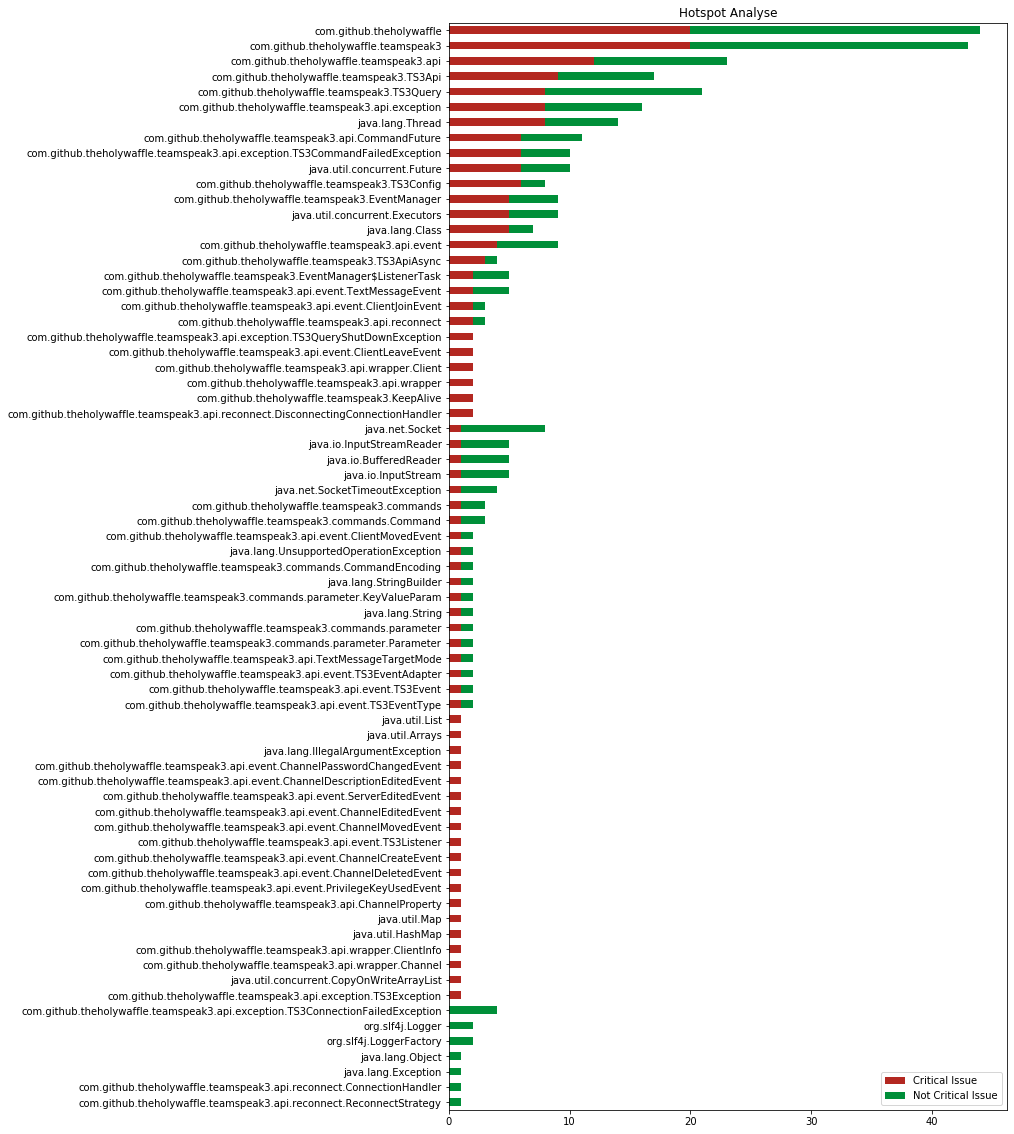

In [35]:
%matplotlib inline

df_diagram.sort_values(by=["Critical Issue","Not Critical Issue"],inplace=True)




ax=df_diagram.plot(kind='barh',stacked=True,figsize=(10,20),title="Hotspot Analyse",color=['#b32821', '#008f39'])


# 2. Time analysis (git history)

## a) Connection to the Neo4j database

### 1. Establish a connection to the Neo4j database.

In [36]:
import pandas as pd
query ="MATCH (n:Commit)Where Exists(n.date) RETURN n.date as Time , 1"
df_git = pd.DataFrame(graph.run(query).data())


Collected Git data (time and modifyed filepath from git commits)

## b) Process time data


### 1.Transform time data from git-dataframe



In [37]:
#Time Format
format='%Y-%m-%d'
df_git['Time'] =  pd.to_datetime(df_git['Time'], format=format).dt.date

df_git.head(5)

,Time,1
0,2019-04-15,1
1,2019-04-15,1
2,2019-04-06,1
3,2019-04-06,1
4,2019-04-02,1


### 2. Transform time data from the issue-dataframe


In [38]:
format='%Y%m%d%H%M%S'
df['Time']= pd.to_datetime(df['Time'], format=format).dt.date

### 3. Merge dataframes

In [39]:
bug_date = df[df["class"] == 1]
normal = df[df["class"] == 0]

bug_date=bug_date[["Time","class"]]
normal=normal[["Time","class"]]

bug_date=bug_date.rename(columns={"class":"Critical Issue"})
normal=normal.rename(columns={"class":"Not Critical Issue"})

#Reset value from column

normal["Not Critical Issue"]=1

df_git = df_git.append(bug_date,sort=False,ignore_index=True)
df_git = df_git.append(normal,sort=False,ignore_index=True)


df_git.fillna(0,inplace=True)
df_git.head(5)

,Time,1,Critical Issue,Not Critical Issue
0,2019-04-15,1.0,0.0,0.0
1,2019-04-15,1.0,0.0,0.0
2,2019-04-06,1.0,0.0,0.0
3,2019-04-06,1.0,0.0,0.0
4,2019-04-02,1.0,0.0,0.0


## c) Timing git analysis


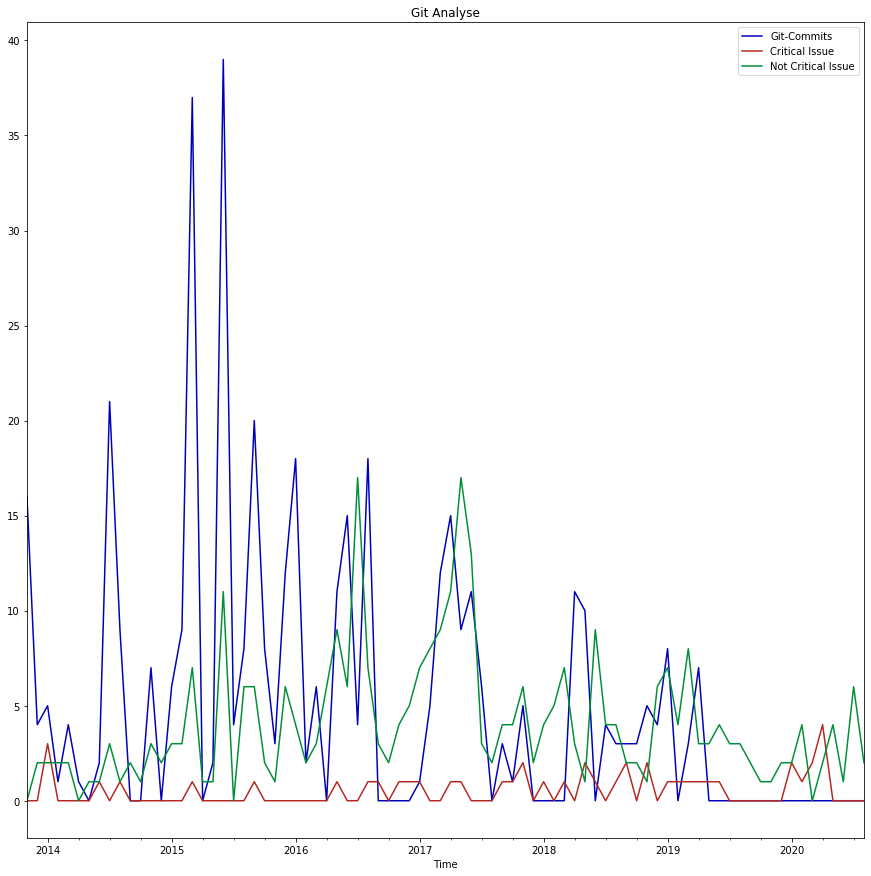

In [40]:
%matplotlib inline
format='%Y-%m-%d'
df_git['Time'] = pd.to_datetime(df_git['Time'],format=format)
df_git=df_git.rename(columns={"1":"Git-Commits"})

test=df_git.groupby(df_git.Time.dt.to_period("M")).sum()
test.plot(figsize=(15,15),title="Git Analyse",color=['#0000BB','#b32821','#008f39'])